In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from torchvision.ops import SqueezeExcitation
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

### Loading data

In [2]:
keys_s = '0123456789abcdefghijklmnopqrstuvwxyz'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [3]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

def convert_to_df(AUDIO_FILE):
    for i, File in enumerate(keys):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)
    return df, sample_rate 

In [4]:
data_frame, sr = convert_to_df("../dataset/Zoom/")

print(data_frame.head())
print(data_frame.info())

  Key                                               File
0   0  [[tensor(-6.1035e-05), tensor(-6.1035e-05), te...
1   0  [[tensor(0.), tensor(-3.0518e-05), tensor(-3.0...
2   0  [[tensor(3.0518e-05), tensor(3.0518e-05), tens...
3   0  [[tensor(-0.0002), tensor(-0.0002), tensor(-0....
4   0  [[tensor(6.1035e-05), tensor(6.1035e-05), tens...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    object
 1   File    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
None


In [6]:
train_set, tmp_set = train_test_split(data_frame, test_size=0.3, stratify=data_frame['Key'])
val_set, test_set = train_test_split(tmp_set, test_size=0.33, stratify=tmp_set['Key'])

print("Sample rate:", sr)
print(len(train_set), len(val_set), len(test_set))

Sample rate: 32000
630 180 90


### Data augmentation setup

In [7]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=2048, win_length=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])
        
train_set = MyDataset(train_set, aug = aug)
val_set = MyDataset(val_set, transform = transform)
test_set = MyDataset(test_set, transform = transform)

### Training set image (augmented vs non-augmented)

torch.Size([64, 64])


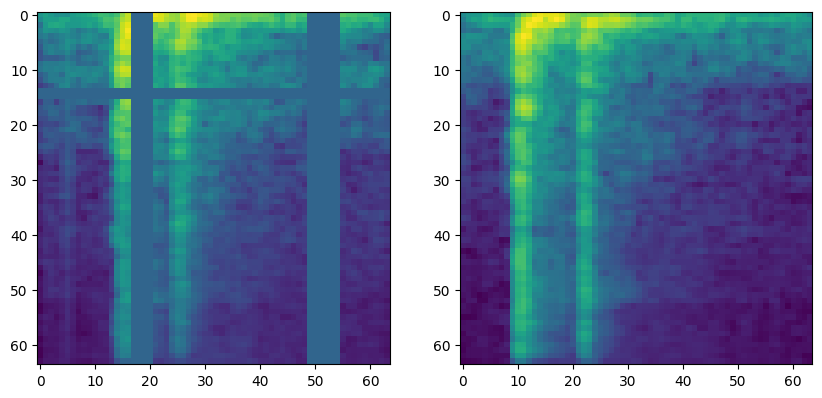

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_set[0][0][0], cmap='viridis')
ax2.imshow(val_set[0][0][0], cmap='viridis')
print(train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [9]:
print("number of classes:", len(np.unique(data_frame['Key'])))

number of classes: 36


### CoAtNet (Model)

In [10]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [11]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [12]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [13]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [14]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [15]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [16]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [18]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [19]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [20]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

/mnt/c/Users/seyyedaliayati/Documents/CSCE689_LLM/venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
Layer (type:depth-idx)                                  Param #
├─Sequential: 1-1                                       --
|    └─Stem: 2-1                                        --
|    |    └─Conv2d: 3-1                                 640
|    |    └─BatchNorm2d: 3-2                            128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,928
├─Sequential: 1-2                                       --
|    └─DownsamplingMBConv: 2-2                          --
|    |    └─Sequential: 3-5                             78,304
|    |    └─Conv2d: 3-6                                 6,144
|    |    └─MaxPool2d: 3-7                              --
|    └─MBConv: 2-3                                      --
|    |    └─Sequential: 3-8                             154,176
├─Sequential: 1-3                                       --
|    └─DownsamplingMBConv: 2-4                          --


Layer (type:depth-idx)                                  Param #
├─Sequential: 1-1                                       --
|    └─Stem: 2-1                                        --
|    |    └─Conv2d: 3-1                                 640
|    |    └─BatchNorm2d: 3-2                            128
|    |    └─GELU: 3-3                                   --
|    |    └─Conv2d: 3-4                                 36,928
├─Sequential: 1-2                                       --
|    └─DownsamplingMBConv: 2-2                          --
|    |    └─Sequential: 3-5                             78,304
|    |    └─Conv2d: 3-6                                 6,144
|    |    └─MaxPool2d: 3-7                              --
|    └─MBConv: 2-3                                      --
|    |    └─Sequential: 3-8                             154,176
├─Sequential: 1-3                                       --
|    └─DownsamplingMBConv: 2-4                          --
|    |    └─Sequential: 3-9      

### Training

In [23]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [24]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [25]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [26]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [27]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

Epoch [1/1100], Loss: 17.76641273498535, Accuracy: 0.046031746031746035 Correct: 29 Total: 630 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.044444444444444446 Validation loss: 20.027658462524414 Correct: 8 Total: 180
Epoch [2/1100], Loss: 9.644843101501465, Accuracy: 0.06984126984126984 Correct: 44 Total: 630 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.08333333333333333 Validation loss: 5.032774448394775 Correct: 15 Total: 180
Epoch [3/1100], Loss: 6.283599853515625, Accuracy: 0.06825396825396825 Correct: 43 Total: 630 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.1 Validation loss: 4.306367874145508 Correct: 18 Total: 180
Epoch [4/1100], Loss: 4.801210403442383, Accuracy: 0.10158730158730159 Correct: 64 Total: 630 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.11666666666666667 Validation loss: 4.01286506652832 Correct: 21 Total: 180
Epoch [5/1100], Loss: 3.9439289569854736, Accuracy: 0.11

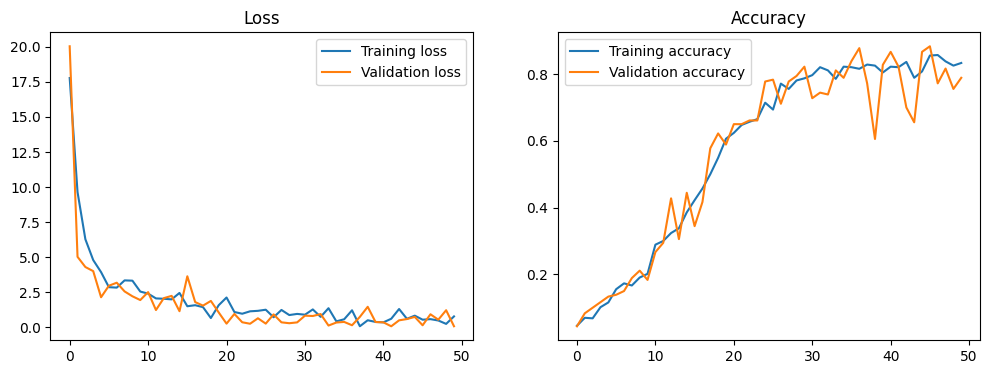

Epoch [51/1100], Loss: 0.9777808785438538, Accuracy: 0.8492063492063492 Correct: 535 Total: 630 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.7666666666666667 Validation loss: 1.7839155197143555 Correct: 138 Total: 180
Epoch [52/1100], Loss: 0.47586023807525635, Accuracy: 0.8174603174603174 Correct: 515 Total: 630 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.8166666666666667 Validation loss: 0.8886861801147461 Correct: 147 Total: 180
Epoch [53/1100], Loss: 0.5399162173271179, Accuracy: 0.8412698412698413 Correct: 530 Total: 630 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.6388888888888888 Validation loss: 2.5148744583129883 Correct: 115 Total: 180
Epoch [54/1100], Loss: 0.514415979385376, Accuracy: 0.8158730158730159 Correct: 514 Total: 630 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.8666666666666667 Validation loss: 0.7894312143325806 Correct: 156 Total: 180
Epoch [55/

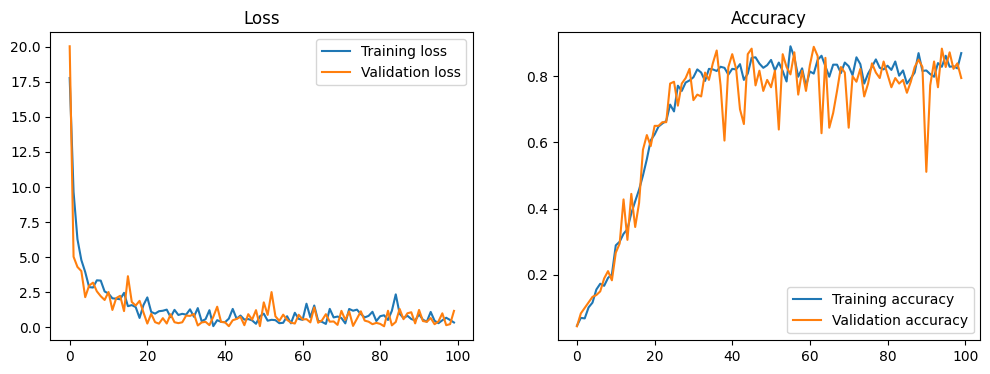

Epoch [101/1100], Loss: 1.1799854040145874, Accuracy: 0.819047619047619 Correct: 516 Total: 630 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.7888888888888889 Validation loss: 1.9230862855911255 Correct: 142 Total: 180
Epoch [102/1100], Loss: 0.477734237909317, Accuracy: 0.8174603174603174 Correct: 515 Total: 630 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.8333333333333334 Validation loss: 1.9433610439300537 Correct: 150 Total: 180
Epoch [103/1100], Loss: 1.1533528566360474, Accuracy: 0.8238095238095238 Correct: 519 Total: 630 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.6611111111111111 Validation loss: 2.136849880218506 Correct: 119 Total: 180
Epoch [104/1100], Loss: 0.662808895111084, Accuracy: 0.773015873015873 Correct: 487 Total: 630 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.7166666666666667 Validation loss: 0.4424346089363098 Correct: 129 Total: 180
Epoch [105

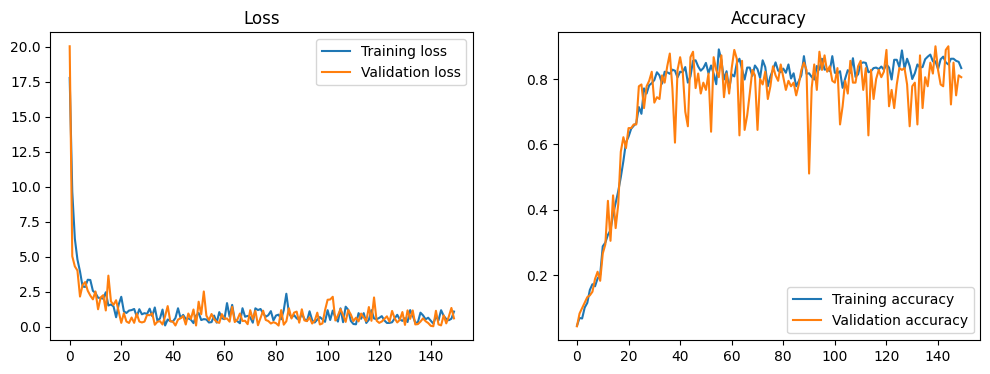

Epoch [151/1100], Loss: 0.28543540835380554, Accuracy: 0.8444444444444444 Correct: 532 Total: 630 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.8611111111111112 Validation loss: 0.6315314769744873 Correct: 155 Total: 180
Epoch [152/1100], Loss: 0.9147422909736633, Accuracy: 0.8746031746031746 Correct: 551 Total: 630 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.85 Validation loss: 0.3076074421405792 Correct: 153 Total: 180
Epoch [153/1100], Loss: 0.6836386322975159, Accuracy: 0.8523809523809524 Correct: 537 Total: 630 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.7833333333333333 Validation loss: 1.0548781156539917 Correct: 141 Total: 180
Epoch [154/1100], Loss: 0.1721772402524948, Accuracy: 0.8555555555555555 Correct: 539 Total: 630 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8 Validation loss: 0.8741970658302307 Correct: 144 Total: 180
Epoch [155/1100], Loss: 0.17325520

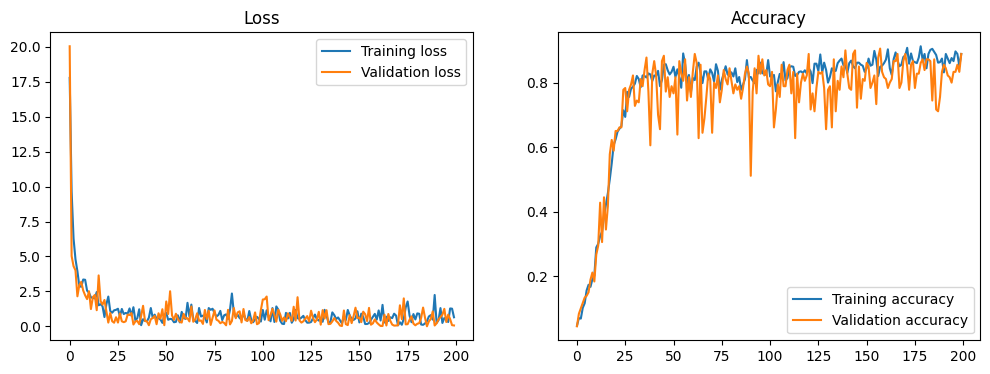

Epoch [201/1100], Loss: 0.14484719932079315, Accuracy: 0.9063492063492063 Correct: 571 Total: 630 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8666666666666667 Validation loss: 0.05303822457790375 Correct: 156 Total: 180
Epoch [202/1100], Loss: 0.5676349997520447, Accuracy: 0.9142857142857143 Correct: 576 Total: 630 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.9055555555555556 Validation loss: 0.029148926958441734 Correct: 163 Total: 180
Epoch [203/1100], Loss: 1.328539490699768, Accuracy: 0.8380952380952381 Correct: 528 Total: 630 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.7722222222222223 Validation loss: 1.557004690170288 Correct: 139 Total: 180
Epoch [204/1100], Loss: 0.3300415575504303, Accuracy: 0.8841269841269841 Correct: 557 Total: 630 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8833333333333333 Validation loss: 0.22735826671123505 Correct: 159 Total: 180
E

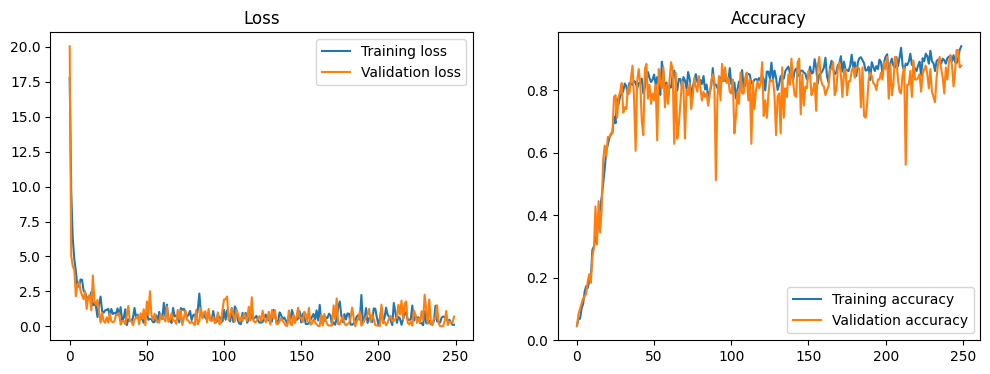

Epoch [251/1100], Loss: 0.35794147849082947, Accuracy: 0.919047619047619 Correct: 579 Total: 630 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8388888888888889 Validation loss: 0.08186040818691254 Correct: 151 Total: 180
Epoch [252/1100], Loss: 0.32137104868888855, Accuracy: 0.8793650793650793 Correct: 554 Total: 630 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.8277777777777777 Validation loss: 0.5268219709396362 Correct: 149 Total: 180
Epoch [253/1100], Loss: 0.8841668963432312, Accuracy: 0.8841269841269841 Correct: 557 Total: 630 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.8444444444444444 Validation loss: 0.4200761616230011 Correct: 152 Total: 180
Epoch [254/1100], Loss: 0.259417325258255, Accuracy: 0.9317460317460318 Correct: 587 Total: 630 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.6944444444444444 Validation loss: 0.270076185464859 Correct: 125 Total: 180
Epoc

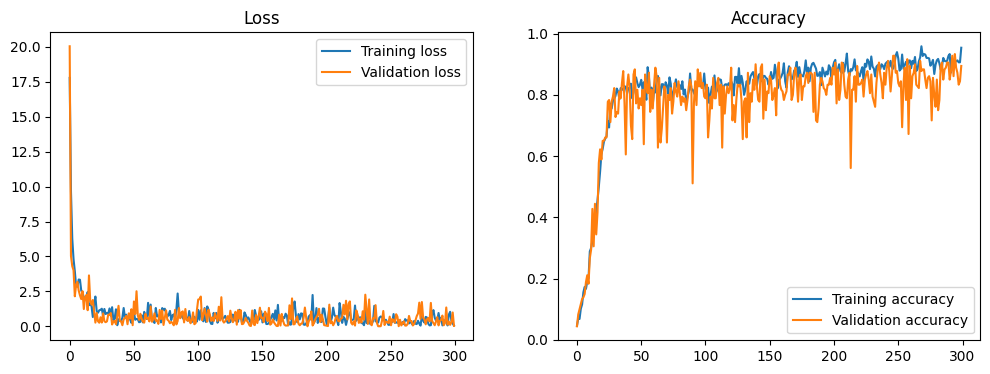

Epoch [301/1100], Loss: 0.5381305813789368, Accuracy: 0.9301587301587302 Correct: 586 Total: 630 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8666666666666667 Validation loss: 0.193048357963562 Correct: 156 Total: 180
Epoch [302/1100], Loss: 0.29161691665649414, Accuracy: 0.9047619047619048 Correct: 570 Total: 630 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8888888888888888 Validation loss: 0.009750165045261383 Correct: 160 Total: 180
Epoch [303/1100], Loss: 0.09997975826263428, Accuracy: 0.9222222222222223 Correct: 581 Total: 630 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.8333333333333334 Validation loss: 0.28430813550949097 Correct: 150 Total: 180
Epoch [304/1100], Loss: 0.40267884731292725, Accuracy: 0.9317460317460318 Correct: 587 Total: 630 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.8388888888888889 Validation loss: 1.215378999710083 Correct: 151 Total: 180


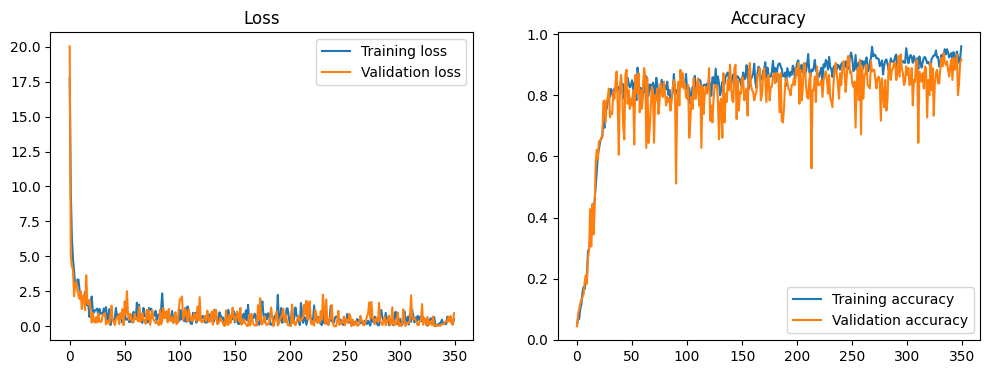

Epoch [351/1100], Loss: 0.347888708114624, Accuracy: 0.9047619047619048 Correct: 570 Total: 630 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.9222222222222223 Validation loss: 0.37177059054374695 Correct: 166 Total: 180
Epoch [352/1100], Loss: 0.23787319660186768, Accuracy: 0.9444444444444444 Correct: 595 Total: 630 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9 Validation loss: 0.06592147052288055 Correct: 162 Total: 180
Epoch [353/1100], Loss: 0.5192709565162659, Accuracy: 0.926984126984127 Correct: 584 Total: 630 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.8444444444444444 Validation loss: 0.07227906584739685 Correct: 152 Total: 180
Epoch [354/1100], Loss: 0.3818422555923462, Accuracy: 0.9 Correct: 567 Total: 630 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.9 Validation loss: 0.15150892734527588 Correct: 162 Total: 180
Epoch [355/1100], Loss: 0.42984986305236816, Accu

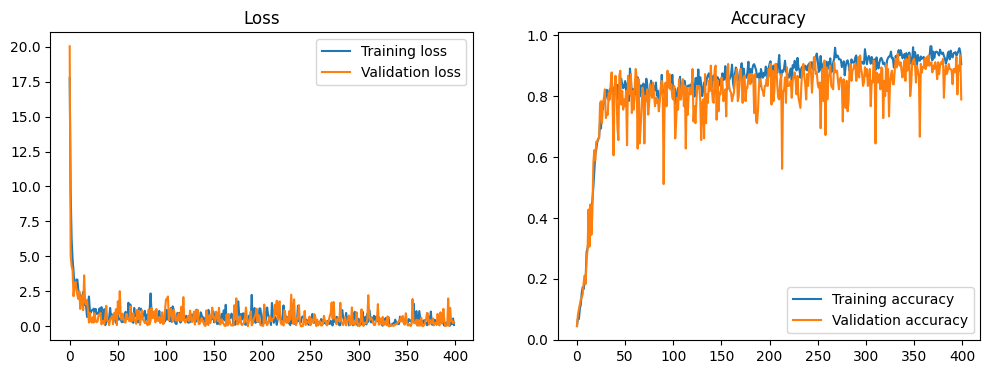

Epoch [401/1100], Loss: 1.1708413362503052, Accuracy: 0.9428571428571428 Correct: 594 Total: 630 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.8888888888888888 Validation loss: 0.5549748539924622 Correct: 160 Total: 180
Epoch [402/1100], Loss: 0.23246009647846222, Accuracy: 0.9142857142857143 Correct: 576 Total: 630 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.9 Validation loss: 0.9192926287651062 Correct: 162 Total: 180
Epoch [403/1100], Loss: 0.8827888369560242, Accuracy: 0.9253968253968254 Correct: 583 Total: 630 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.8333333333333334 Validation loss: 0.322731614112854 Correct: 150 Total: 180
Epoch [404/1100], Loss: 0.3532368838787079, Accuracy: 0.9333333333333333 Correct: 588 Total: 630 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.9333333333333333 Validation loss: 0.20996390283107758 Correct: 168 Total: 180
Epoch [405/1100], 

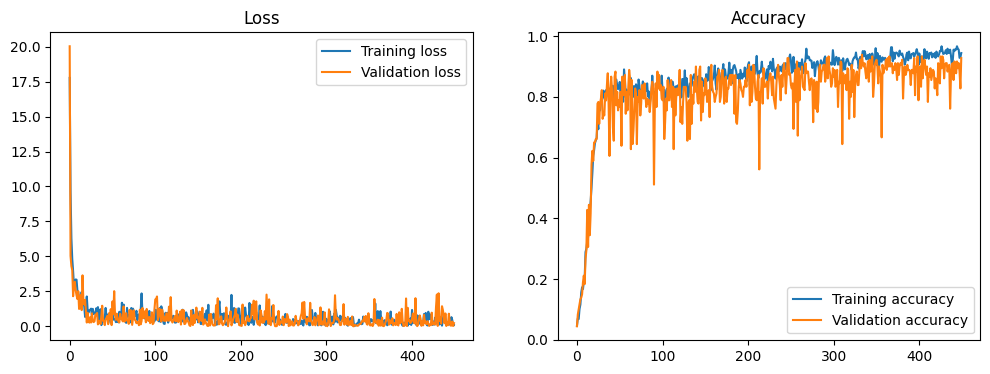

Epoch [451/1100], Loss: 0.28856852650642395, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.9 Validation loss: 0.8021289110183716 Correct: 162 Total: 180
Epoch [452/1100], Loss: 0.07298790663480759, Accuracy: 0.9507936507936507 Correct: 599 Total: 630 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.8722222222222222 Validation loss: 0.8762950301170349 Correct: 157 Total: 180
Epoch [453/1100], Loss: 0.581913948059082, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.9166666666666666 Validation loss: 0.06041711941361427 Correct: 165 Total: 180
Epoch [454/1100], Loss: 0.06941929459571838, Accuracy: 0.9555555555555556 Correct: 602 Total: 630 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.8833333333333333 Validation loss: 0.06323429942131042 Correct: 159 Total: 180
Epoch [455/1100], 

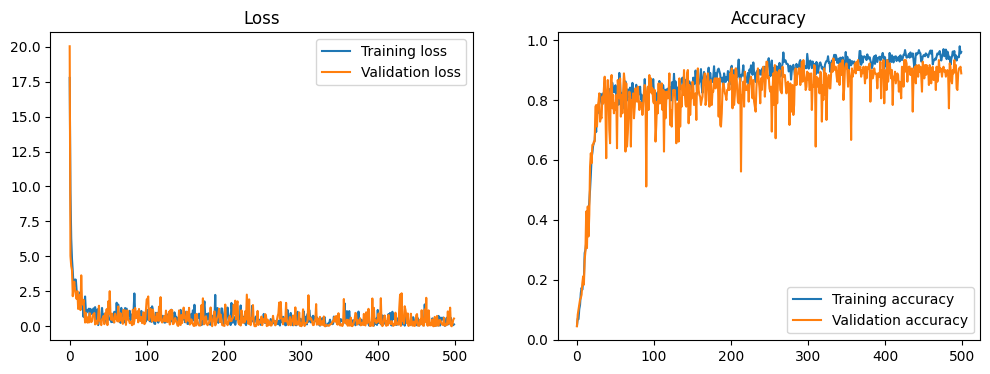

Epoch [501/1100], Loss: 0.05833135545253754, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.8555555555555555 Validation loss: 1.5393856763839722 Correct: 154 Total: 180
Epoch [502/1100], Loss: 0.2182478904724121, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.9111111111111111 Validation loss: 0.11653316020965576 Correct: 164 Total: 180
Epoch [503/1100], Loss: 0.2625373303890228, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9333333333333333 Validation loss: 0.03673722967505455 Correct: 168 Total: 180
Epoch [504/1100], Loss: 0.16429048776626587, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.9 Validation loss: 0.22462999820709229 Correct: 162 Total: 180
Epoch [505/110

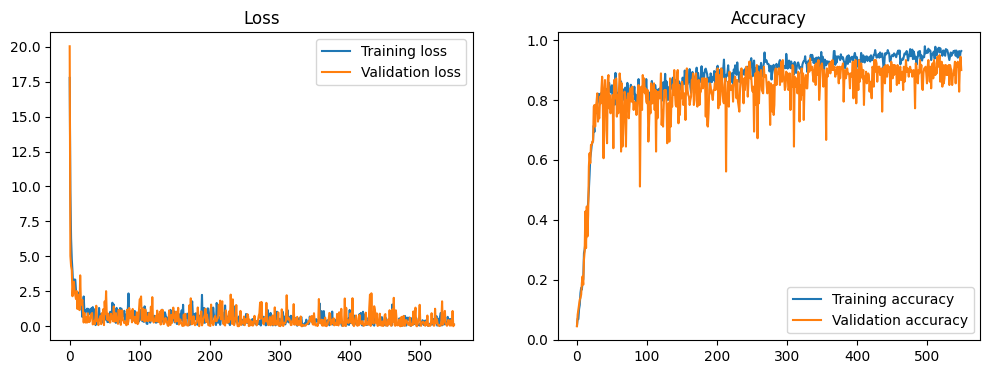

Epoch [551/1100], Loss: 0.26111307740211487, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.9055555555555556 Validation loss: 0.0358663946390152 Correct: 163 Total: 180
Epoch [552/1100], Loss: 0.07689940184354782, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.8888888888888888 Validation loss: 0.6408331394195557 Correct: 160 Total: 180
Epoch [553/1100], Loss: 0.6492987275123596, Accuracy: 0.9587301587301588 Correct: 604 Total: 630 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.9111111111111111 Validation loss: 0.10625197738409042 Correct: 164 Total: 180
Epoch [554/1100], Loss: 0.12742848694324493, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.8333333333333334 Validation loss: 1.247765064239502 Correct: 150 Total: 180
Ep

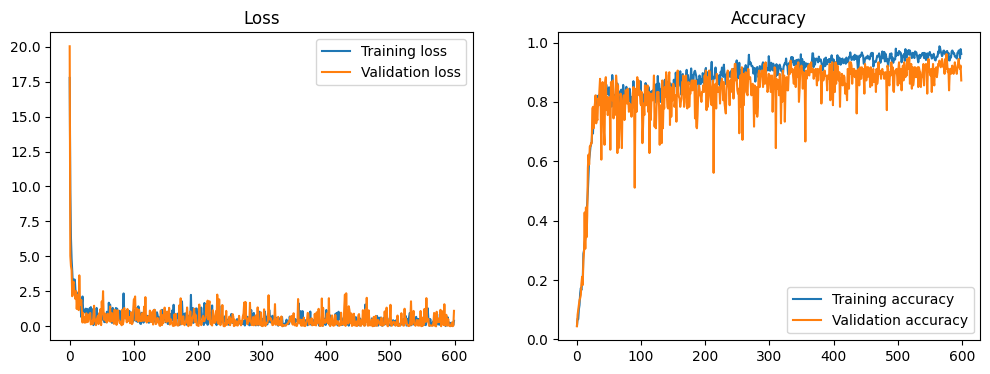

Epoch [601/1100], Loss: 0.08802487701177597, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.85 Validation loss: 1.4484548568725586 Correct: 153 Total: 180
Epoch [602/1100], Loss: 0.3043731451034546, Accuracy: 0.9333333333333333 Correct: 588 Total: 630 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.8611111111111112 Validation loss: 0.2999747097492218 Correct: 155 Total: 180
Epoch [603/1100], Loss: 0.20651845633983612, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.9166666666666666 Validation loss: 0.04874025657773018 Correct: 165 Total: 180
Epoch [604/1100], Loss: 0.05070999637246132, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9277777777777778 Validation loss: 0.3067516088485718 Correct: 167 Total: 180
Epoch [605/1

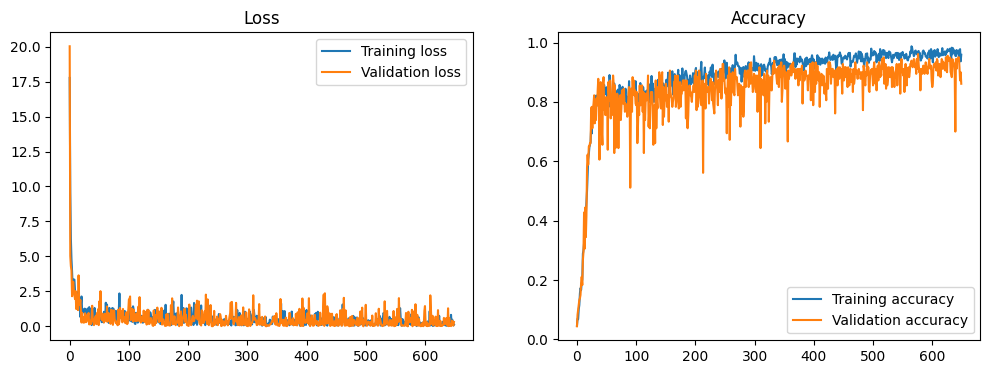

Epoch [651/1100], Loss: 0.12126819044351578, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.8944444444444445 Validation loss: 0.015068795531988144 Correct: 161 Total: 180
Epoch [652/1100], Loss: 0.02258925884962082, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.9277777777777778 Validation loss: 0.13964787125587463 Correct: 167 Total: 180
Epoch [653/1100], Loss: 0.16332335770130157, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9388888888888889 Validation loss: 0.43999502062797546 Correct: 169 Total: 180
Epoch [654/1100], Loss: 0.08424818515777588, Accuracy: 0.9682539682539683 Correct: 610 Total: 630 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9 Validation loss: 0.022002331912517548 Correct: 162 Total: 180
Epoch [655

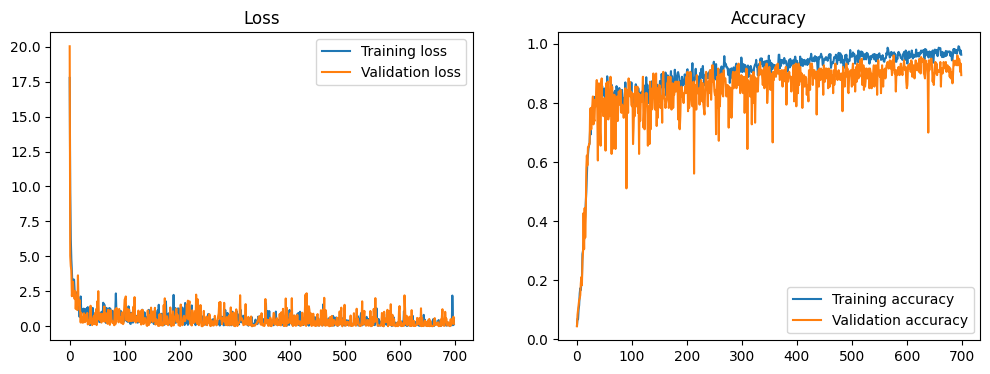

Epoch [701/1100], Loss: 0.14049206674098969, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9222222222222223 Validation loss: 0.20919397473335266 Correct: 166 Total: 180
Epoch [702/1100], Loss: 0.26474466919898987, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9 Validation loss: 0.21998026967048645 Correct: 162 Total: 180
Epoch [703/1100], Loss: 0.36993029713630676, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9333333333333333 Validation loss: 0.29440537095069885 Correct: 168 Total: 180
Epoch [704/1100], Loss: 0.4221184253692627, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9111111111111111 Validation loss: 0.030996693298220634 Correct: 164 Total: 180
Epoch [705/

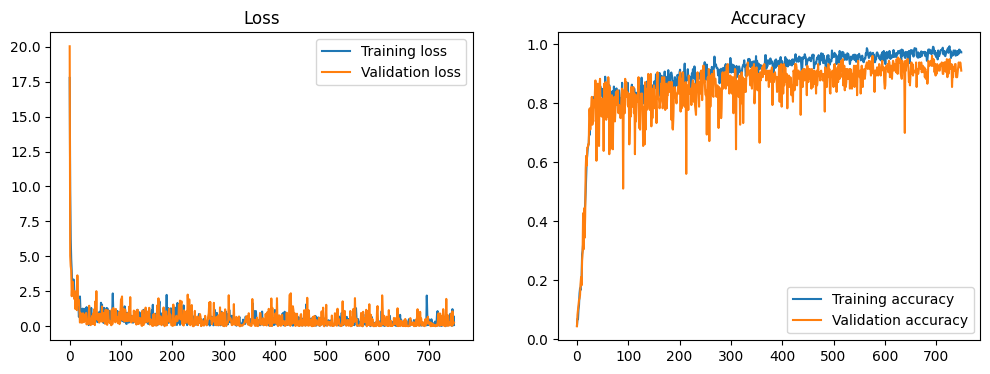

Epoch [751/1100], Loss: 0.3267560601234436, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9222222222222223 Validation loss: 0.7086017727851868 Correct: 166 Total: 180
Epoch [752/1100], Loss: 0.11503860354423523, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.8944444444444445 Validation loss: 0.23638570308685303 Correct: 161 Total: 180
Epoch [753/1100], Loss: 0.058477550745010376, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9222222222222223 Validation loss: 0.5845894813537598 Correct: 166 Total: 180
Epoch [754/1100], Loss: 0.05520083010196686, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9333333333333333 Validation loss: 0.34953612089157104 Correct: 168 Total: 18

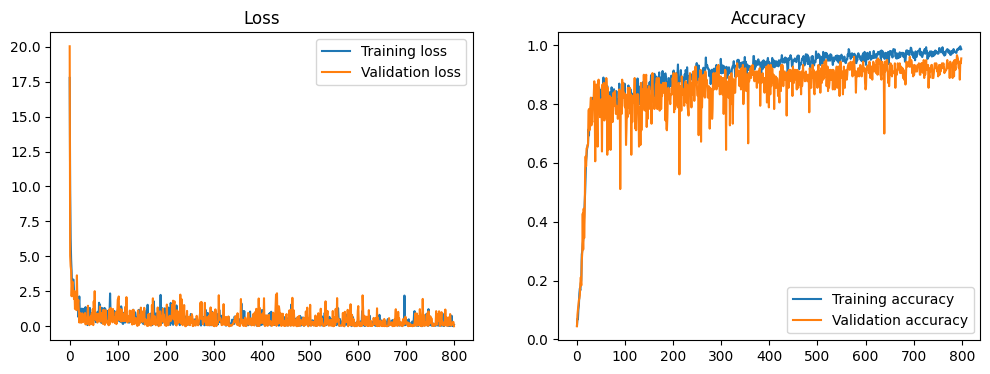

Epoch [801/1100], Loss: 0.25079309940338135, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9222222222222223 Validation loss: 0.06050502508878708 Correct: 166 Total: 180
Epoch [802/1100], Loss: 0.19406944513320923, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9055555555555556 Validation loss: 0.5095300078392029 Correct: 163 Total: 180
Epoch [803/1100], Loss: 0.30580270290374756, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9055555555555556 Validation loss: 0.10054858773946762 Correct: 163 Total: 180
Epoch [804/1100], Loss: 0.04417312145233154, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9444444444444444 Validation loss: 0.17156429588794708 Correct: 170 Total: 180

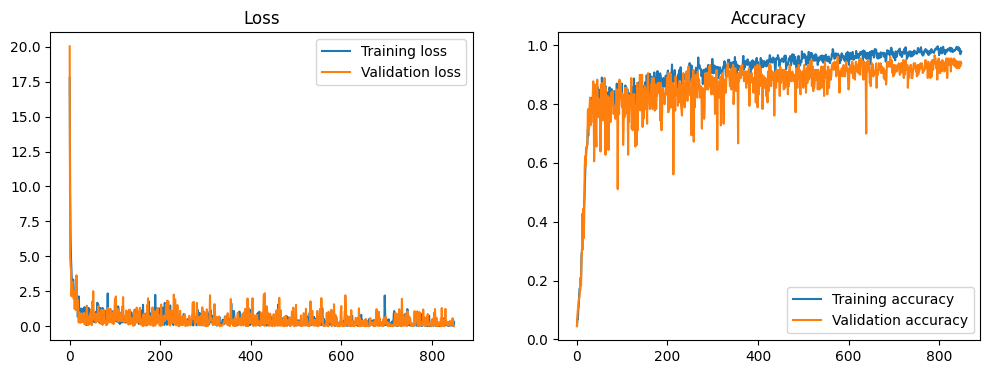

Epoch [851/1100], Loss: 0.12842196226119995, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9222222222222223 Validation loss: 0.16936248540878296 Correct: 166 Total: 180
Epoch [852/1100], Loss: 0.03401778265833855, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9277777777777778 Validation loss: 1.0776382684707642 Correct: 167 Total: 180
Epoch [853/1100], Loss: 0.34201955795288086, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9333333333333333 Validation loss: 0.21359769999980927 Correct: 168 Total: 180
Epoch [854/1100], Loss: 0.05262177065014839, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9388888888888889 Validation loss: 0.5566205978393555 Correct: 169 Total: 

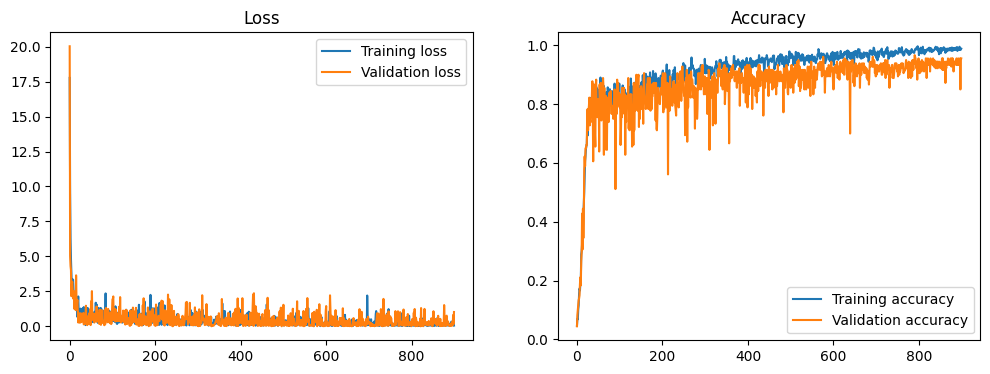

Epoch [901/1100], Loss: 0.10675808042287827, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9222222222222223 Validation loss: 0.3487861156463623 Correct: 166 Total: 180
Epoch [902/1100], Loss: 0.014796431176364422, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.9333333333333333 Validation loss: 0.19810903072357178 Correct: 168 Total: 180
Epoch [903/1100], Loss: 0.15351347625255585, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9444444444444444 Validation loss: 0.12177004665136337 Correct: 170 Total: 180
Epoch [904/1100], Loss: 0.021291164681315422, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9111111111111111 Validation loss: 0.35385382175445557 Correct: 164 Total: 180

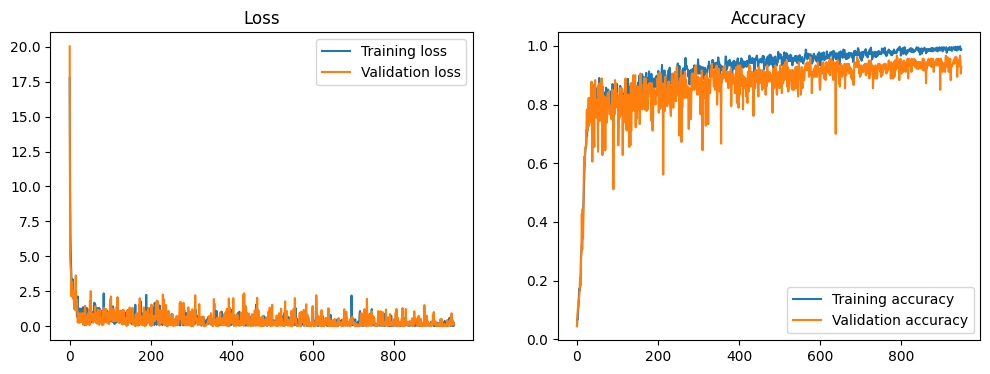

Epoch [951/1100], Loss: 0.21226561069488525, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9388888888888889 Validation loss: 0.05906946212053299 Correct: 169 Total: 180
Epoch [952/1100], Loss: 0.43151506781578064, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9388888888888889 Validation loss: 0.04904508590698242 Correct: 169 Total: 180
Epoch [953/1100], Loss: 0.060957714915275574, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9333333333333333 Validation loss: 0.05011638626456261 Correct: 168 Total: 180
Epoch [954/1100], Loss: 0.2508953809738159, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9333333333333333 Validation loss: 0.2268095314502716 Correct: 168 Total: 180
E

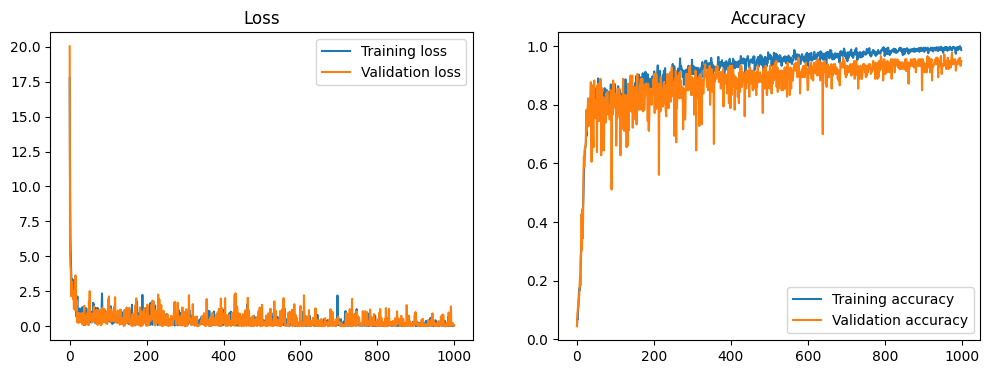

Epoch [1001/1100], Loss: 0.18182004988193512, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.25992143154144287 Correct: 174 Total: 180
Epoch [1002/1100], Loss: 0.017372218891978264, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.16279250383377075 Correct: 172 Total: 180
Epoch [1003/1100], Loss: 0.008260008879005909, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.20521648228168488 Correct: 173 Total: 180
Epoch [1004/1100], Loss: 0.10372930020093918, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.95 Validation loss: 0.1447497457265854 Correct: 171 Total: 180
Epoch [

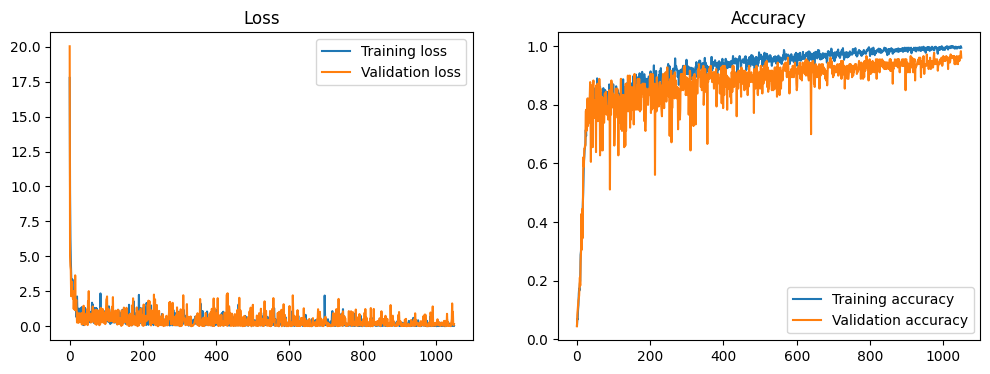

Epoch [1051/1100], Loss: 0.065369613468647, Accuracy: 1.0 Correct: 630 Total: 630 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.19118088483810425 Correct: 175 Total: 180
Epoch [1052/1100], Loss: 0.015065017156302929, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.021275686100125313 Correct: 175 Total: 180
Epoch [1053/1100], Loss: 0.06618460267782211, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.33072206377983093 Correct: 173 Total: 180
Epoch [1054/1100], Loss: 0.0321367047727108, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.5249210000038147 Correct: 172 Total: 180
Epoch [

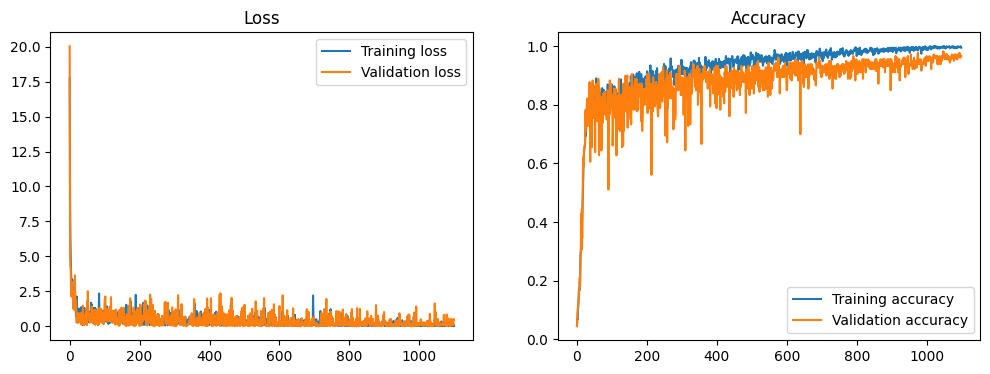

In [28]:
best_model_path = "CoAtNet-1-Best-Zoom.pkl"
model_path = "CoAtNet-1-Zoom.pkl"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [29]:
save_model(model, model_path)

### Results

In [30]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

/tmp/ipykernel_4445/4086271846.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [31]:
print("Best validation acc: ", max(val_accuracies))
print("Last validation acc: ", val_accuracies[-1])

Best validation acc:  0.9833333333333333
Last validation acc:  0.9666666666666667


In [32]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [33]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-zoom.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

### Test accuracy

In [35]:
cm = predict(test_dataloader)

Test Accuracy: 0.9888888888888889


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
predicted_labels,7,U,4,K,D,T,E,2,0,R,2,S,B,8,A,0,F,L,W,8,1,C,F,N,8,Y,W,G,T,J,H,P,Y,R,7,Q,O,J,M,L,Z,I,G,D,T,S,X,K,4,V,C,6,U,6,3,6,G,O,P,0,9,H,M,K,X,W,P,F,I,9,5,Z,B,7,3,A,V,Z,I,E,O,B,1,2,9,5,Q,N,D,N
true_labels,7,U,4,K,D,T,E,2,0,R,1,S,B,8,A,0,F,L,W,8,1,C,F,N,8,Y,W,G,T,J,H,P,Y,R,7,Q,O,J,M,L,Z,I,G,D,T,S,X,K,4,V,C,6,U,6,3,6,G,O,P,0,9,H,M,K,X,W,P,F,I,9,5,Z,B,7,3,A,V,Z,I,E,O,B,1,2,9,5,Q,N,D,N


0.9888888888888889
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.67      0.80         3
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
        

### Confusion matrix

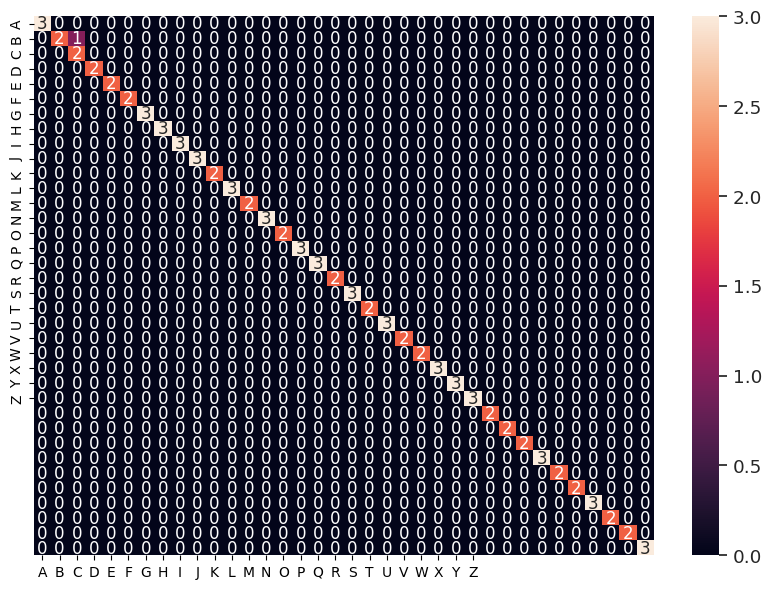

In [36]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1")